In [11]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import scipy.sparse
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pickle
from tqdm import tqdm
from sklearn import utils
import multiprocessing
from nltk.tokenize import word_tokenize
import json
import numpy as np
import scipy.sparse
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, ConfusionMatrixDisplay
import pickle
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
import pickle
import matplotlib.pyplot as plt
import json
from sklearn.pipeline import Pipeline

## Read Inputs

In [3]:
texts = np.load("preprocessed_texts.npy", allow_pickle = True)
labels = np.load("preprocessed_labels.npy", allow_pickle = True)

## Transformation

Configuration for Transformation

In [ ]:
# TF-IDF | CountVectorization | BERT | DOC2VEC
method = "TF-IDF"
dimension = 200 # Doc2Vec vector dimension
epochs = 10 # Doc2Vec training epochs
min_df = 0.001 # TF-IDF min df
max_df = 0.9 # TF-IDF max df
use_idf = False
outer_splits = 3
inner_splits = 3
random_iterations = 1
param_grid = {
    "logistic__C": list(np.logspace(-3,3,7)), 
    "logistic__penalty": ["none", "l2"],
    "vectorizer__min_df": [0.1, 0.01, 0.001, 0.001],
    "vectorizer__max_df": [0.5, 0.6, 0.7, 0.8, 0.9],
    "vectorizer__use_idf": [True, False],
    "bayes__alpha": [0.01, 0.1, 0.5, 1, 10],
    "svm__C": [1, 10, 100, 100], 
    "svm__gamma": [.001, .01, .1, 1]
    }

with open('config.json', 'r') as openfile:
    json_object = json.load(openfile)
    json_object["transformation_method"] = method
    json_object["doc2vec_dimension"] = dimension
    json_object["doc2vec_epochs"] = epochs
    json_object["min_df"] = min_df
    json_object["max_df"] = max_df
    json_object["use_idf"] = use_idf
    json_object["outer_splits"] = outer_splits
    json_object["innter_splits"] = inner_splits
    json_object["param_grid"] = param_grid
with open("config.json", "w") as outfile:
    outfile.write(json.dumps(json_object))

#### Count Vectorization
We cannot use this vectorization methods because the fake news differ in the length of texts from the true news

In [5]:
if method == "CountVectorization":
    vectorizer = CountVectorizer(analyzer="word")
    all_tokens = vectorizer.fit_transform(texts)

#### TF-IDF Vectorization

In [4]:
if method == "TF-IDF":
    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, use_idf=use_idf) #critical values selected from research papers 
    all_tokens = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    print(f"{len(feature_names)} features after using vectorizer.")

13691 features after using vectorizer.


In [6]:
inner_cv = KFold(n_splits=inner_splits, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=outer_splits, shuffle=True, random_state=42)
vectorizer = TfidfVectorizer()

CV run 1
Get data
Perform Randomized Grid Search
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best model:
Accuracy: 0.926834123776327
{'vectorizer__use_idf': False, 'vectorizer__min_df': 0.01, 'vectorizer__max_df': 0.9, 'logistic__penalty': 'l2', 'logistic__C': 0.01}
Test Accuracy: 0.9343846051049044
Test F1: 0.9307572979833592
Test AUC: 0.9340888472069836
[[7384  471]
 [ 511 6600]]
CV run 2
Get data
Perform Randomized Grid Search
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best model:
Accuracy: 0.9619136742509374
{'vectorizer__use_idf': False, 'vectorizer__min_df': 0.1, 'vectorizer__max_df': 0.5, 'logistic__penalty': 'none', 'logistic__C': 1.0}
Test Accuracy: 0.9635841240144327
Test F1: 0.9624422851629798
Test AUC: 0.9637471029212054
[[7438  316]
 [ 229 6983]]
CV run 3
Get data
Perform Randomized Grid Search
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\nicla\anaconda3\envs\classification\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Best model:
Accuracy: 0.9890084904909139
{'vectorizer__use_idf': True, 'vectorizer__min_df': 0.001, 'vectorizer__max_df': 0.7, 'logistic__penalty': 'none', 'logistic__C': 10.0}
Test Accuracy: 0.9920486435921422
Test F1: 0.9916262050524243
Test AUC: 0.9921072048461886
[[7801   71]
 [  48 7046]]
[0.93438461 0.96358412 0.99204864]
Mean accuracy: 0.9633391242371597


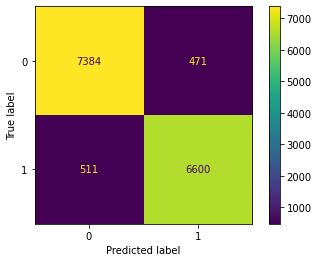

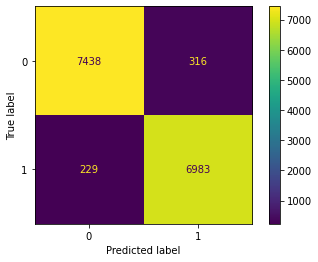

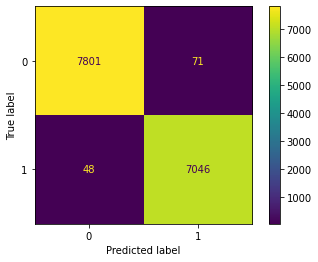

In [15]:
pipeline = Pipeline([("vectorizer", vectorizer), ("logistic", LogisticRegression(max_iter=10000))])
clf = RandomizedSearchCV(pipeline, param_grid, n_iter=random_iterations, cv=inner_cv, n_jobs=-1, verbose=3)
#predictions = cross_val_score(clf, X=texts, y=labels, cv=outer_cv, verbose=3, pre_dispatch=2, n_jobs=-1) # set pre_dispatch lower for less memory consumption
run = 1
accuracies = np.zeros(outer_splits)
for train_index, test_index in outer_cv.split(texts):
    print(f"CV run {run}")
    print("Get data")
    X_train, X_test = texts[train_index], texts[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    print("Perform Randomized Grid Search")
    clf.fit(X_train, y_train)
    print("Best model:")
    print("Accuracy: " + str(clf.best_score_))
    print(clf.best_params_)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    auroc = roc_auc_score(y_test, predictions)
    accuracies[run-1] = accuracy
    print(f"Test Accuracy: {accuracy}")
    print(f"Test F1: {f1}")
    print(f"Test AUC: {auroc}")
    cm = confusion_matrix(y_test, predictions, labels = clf.best_estimator_.classes_)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.savefig("Confusion Matrix Run " + str(run))
    run += 1
print(accuracies)
print(f"Mean accuracy: {accuracies.mean()}")

In [17]:
pipeline = Pipeline([("vectorizer", vectorizer), ("bayes", MultinomialNB())])
clf = RandomizedSearchCV(pipeline, param_grid, n_iter=random_iterations, cv=inner_cv, n_jobs=-1, verbose=3)
run = 1
accuracies = np.zeros(outer_splits)
for train_index, test_index in outer_cv.split(texts):
    print(f"CV run {run}")
    print("Get data")
    X_train, X_test = texts[train_index], texts[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    print("Perform Randomized Grid Search")
    clf.fit(X_train, y_train)
    print("Best model:")
    print("Accuracy: " + str(clf.best_score_))
    print(clf.best_params_)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    auroc = roc_auc_score(y_test, predictions)
    accuracies[run-1] = accuracy
    print(f"Test Accuracy: {accuracy}")
    print(f"Test F1: {f1}")
    print(f"Test AUC: {auroc}")
    cm = confusion_matrix(y_test, predictions, labels = clf.best_estimator_.classes_)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.savefig("Confusion Matrix Run " + str(run))
    run += 1
print(accuracies)
print(f"Mean accuracy: {accuracies.mean()}")

CV run 1
Get data
Perform Randomized Grid Search
Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [ ]:
pipeline = Pipeline([("vectorizer", vectorizer), ("svm", SVC(kernel="rbf"))])
clf = RandomizedSearchCV(pipeline, param_grid, n_iter=random_iterations, cv=inner_cv, n_jobs=-1, verbose=3)
run = 1
accuracies = np.zeros(outer_splits)
for train_index, test_index in outer_cv.split(texts):
    print(f"CV run {run}")
    print("Get data")
    X_train, X_test = texts[train_index], texts[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    print("Perform Randomized Grid Search")
    clf.fit(X_train, y_train)
    print("Best model:")
    print("Accuracy: " + str(clf.best_score_))
    print(clf.best_params_)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    auroc = roc_auc_score(y_test, predictions)
    accuracies[run-1] = accuracy
    print(f"Test Accuracy: {accuracy}")
    print(f"Test F1: {f1}")
    print(f"Test AUC: {auroc}")
    cm = confusion_matrix(y_test, predictions, labels = clf.best_estimator_.classes_)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.savefig("Confusion Matrix Run " + str(run))
    run += 1
print(accuracies)
print(f"Mean accuracy: {accuracies.mean()}")

#### BERT

In [66]:
if method == "BERT":
    tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"
    tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

    print(f'BERT model selected           : {tfhub_handle_encoder}')
    print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

    
    bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
    #if "OSError: SavedModel file does not exist" occurs, navigate to the indicated folder and delete it
    
    text_test = texts
    text_preprocessed = bert_preprocess_model(text_test)

    #print(text_test)
    print(f'Keys       : {list(text_preprocessed.keys())}')
    print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
    print(f'Word Ids   : {text_preprocessed["input_word_ids"]}')
    print(f'Input Mask : {text_preprocessed["input_mask"]}')
    print(f'Type Ids   : {text_preprocessed["input_type_ids"]}')

#### DOC2Vec
Converting the document into vectors

In [68]:
if method == "DOC2VEC":
    tagged_texts = []
    for i, text in enumerate(texts):
            word_tokens = word_tokenize(text)
            tagged_texts.append(TaggedDocument(word_tokens, [i]))
    cores = multiprocessing.cpu_count()

    model = Doc2Vec(dm=0, vector_size=dimension, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model.build_vocab([x for x in tqdm(tagged_texts)])
    for epoch in range(epochs):
        model.train(utils.shuffle([x for x in tqdm(tagged_texts)]), total_examples=len(tagged_texts), epochs=1)
        model.alpha -= 0.002
        model.min_alpha = model.alpha
    vector_list = []
    for i in range(len(texts)):
        vector_list.append(model.dv[i])
    all_tokens = scipy.sparse.csr_matrix(vector_list)

sdf


# Store Results

In [11]:
if method == "TF-IDF" or method == "DOC2VEC":
    scipy.sparse.save_npz("training_input", all_tokens)
    np.save("training_labels", labels)
if method == "TF-IDF":
    np.save("feature_names", feature_names)

if method == "BERT":
    a_file = open("bert_preprocessed.pkl", "wb")
    pickle.dump(text_preprocessed, a_file)
    a_file.close()
    np.save("training_labels", labels)